<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 Parametric Fitting + Regularization Methods for Indoor LoRaWAN Signal Propagation 
</p>

In [33]:
# ==== SPEED HEADER (safe, minimal) ============================================
import os
# Stop BLAS from oversubscribing; we parallelize with joblib instead
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["NUMEXPR_MAX_THREADS"] = "1"

# Joblib process temp in RAM if available (faster)
if os.path.isdir("/dev/shm"):
    os.environ.setdefault("JOBLIB_TEMP_FOLDER", "/dev/shm/joblib")

# Parallelism knob for bootstraps
N_JOBS = 20   # start at 20 on your 7950X; if CPU isn’t ~80–90% busy and RAM is comfy, try 24
# ============================================================================

In [34]:
# ============================== Core & Data Libraries ==============================
import os
import pickle
import numpy as np
import pandas as pd

# ============================== Machine Learning & Stats ===========================
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin, clone
from numpy.linalg import inv

# neat prints
np.set_printoptions(suppress=True, linewidth=120)

# fixed seed for CV components that use randomness
RANDOM_STATE = 42

###  Load data + fold index + basic split

In [35]:
# Path to the standardized database directory
base_path = '../Extended Parametric Regression Files+Plots'

# Load train and test splits# Path to standardized data
base_path = '../Extended Parametric Regression Files+Plots'

# Train/test splits
df_train = pd.read_csv(f"{base_path}/train.csv")
df_test  = pd.read_csv(f"{base_path}/test.csv")

df_train = df_train.sort_values('time').reset_index(drop=True).iloc[::20].reset_index(drop=True)
df_test  = df_test.sort_values('time').reset_index(drop=True).iloc[::20].reset_index(drop=True)


# Raw feature set (distance, freq, walls, env, snr)
feature_names = [
    'distance', 'frequency', 'c_walls', 'w_walls', 'co2', 'humidity',
    'pm25', 'pressure', 'temperature', 'snr'
]

X_train_raw = df_train[feature_names].values
y_train     = df_train['PL'].values
X_test_raw  = df_test[feature_names].values
y_test      = df_test['PL'].values

# Optional time columns if needed later
time_train = df_train.get('time', pd.Series(np.arange(len(df_train)))).values
time_test  = df_test.get('time',  pd.Series(np.arange(len(df_test)))).values

print(f"Training samples: {X_train_raw.shape[0]}, Test samples: {X_test_raw.shape[0]}")

# Leakage-safe fold assignments (grouped-by-device, time-blocked) prepared offline
fold_assignments = np.load(f"{base_path}/train_folds.npy")
unique, counts = np.unique(fold_assignments, return_counts=True)
print("Fold distribution:", dict(zip(unique, counts)))

Training samples: 67072, Test samples: 16768
Fold distribution: {np.int64(0): np.int64(268287), np.int64(1): np.int64(268286), np.int64(2): np.int64(268286), np.int64(3): np.int64(268286), np.int64(4): np.int64(268286)}


### Model linearization (log-distance + freq offset)

In [36]:
# Linearization separates the non-linear frequency term and transforms distance
# LDPL: pull 20*log10(f) to the RHS as a fixed offset; transform distance to 10*log10(d/d0)
d0 = 1.0

# Train transforms
log_d_train  = np.log10(np.clip(X_train_raw[:, 0], 1e-9, None) / d0)
offset_train = 20.0 * np.log10(np.clip(X_train_raw[:, 1], 1e-9, None))
X_lin_train  = np.column_stack([
    10.0 * log_d_train,           # index 0: distance term for exponent n
    X_train_raw[:, 2:10]          # indices 1..8: c_walls, w_walls, co2, humidity, pm25, pressure, temperature, snr
])
y_train_adj  = y_train - offset_train

# Test transforms
log_d_test  = np.log10(np.clip(X_test_raw[:, 0], 1e-9, None) / d0)
offset_test = 20.0 * np.log10(np.clip(X_test_raw[:, 1], 1e-9, None))
X_lin_test  = np.column_stack([
    10.0 * log_d_test,
    X_test_raw[:, 2:10]
])
y_test_adj  = y_test - offset_test

p = X_lin_train.shape[1]
print(f"Linearized feature dimensionality (p): {p}")

Linearized feature dimensionality (p): 9


### Model builders (linear + poly(2))

In [37]:
# ---------- Linear (degree=1): OLS + L2 + L1 + EN ----------
def build_mlr_linear():
    # Standardize features; plain OLS on adjusted target
    return make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LinearRegression()
    )

def build_ridge_linear():
    alphas = np.logspace(-6, 6, 100)
    return make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    )

def build_lasso_linear():
    alphas = np.logspace(-6, 2, 60)
    return make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        LassoCV(alphas=alphas, cv=5, random_state=RANDOM_STATE, max_iter=200000)
    )

def build_enet_linear():
    alphas = np.logspace(-6, 2, 40)
    l1_ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
    return make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5,
                     random_state=RANDOM_STATE, max_iter=300000, tol=1e-3,
                     n_jobs=-1, precompute='auto')
    )

# ---- degree-2 expansion only on continuous vars + SNR; walls kept linear ----------
# X_lin columns: [0]=distance, [1]=c_walls, [2]=w_walls, [3]=co2, [4]=humidity, [5]=pm25, [6]=pressure, [7]=temperature, [8]=snr
POLY_KEEP_LINEAR_IDXS = [1, 2]                      # keep walls linear
POLY_EXPAND_IDXS      = [0, 3, 4, 5, 6, 7, 8]       # expand distance + env + SNR 

class PolyOnContinuous(TransformerMixin):
    def __init__(self, keep_idxs=POLY_KEEP_LINEAR_IDXS, expand_idxs=POLY_EXPAND_IDXS, degree=2):
        self.keep_idxs = keep_idxs
        self.expand_idxs = expand_idxs
        self.degree = degree
        self.poly_ = None
    def fit(self, X, y=None):
        X = np.asarray(X, dtype=float)
        self.poly_ = PolynomialFeatures(self.degree, include_bias=False).fit(X[:, self.expand_idxs])
        return self
    def transform(self, X):
        X = np.asarray(X, dtype=float)
        X_lin = X[:, self.keep_idxs]
        X_cont_poly = self.poly_.transform(X[:, self.expand_idxs])
        return np.hstack([X_lin, X_cont_poly])

def build_poly_regr():
    # OLS on degree-2 map (squares + pairwise interactions); walls remain additive in X
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(with_mean=True, with_std=True),
        LinearRegression()
    )

def build_ridge_poly2():
    alphas = np.logspace(-6, 6, 100)
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(with_mean=True, with_std=True),
        RidgeCV(alphas=alphas, cv=5, scoring='neg_mean_squared_error')
    )

def build_lasso_poly2():
    alphas = np.logspace(-6, 0, 50)
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(with_mean=True, with_std=True),
        LassoCV(alphas=alphas, cv=5, random_state=RANDOM_STATE, max_iter=200000)
    )

def build_enet_poly2():
    alphas = np.logspace(-3, 0, 30)
    l1_ratios = [0.2, 0.4, 0.6, 0.8]
    return make_pipeline(
        PolyOnContinuous(),
        StandardScaler(with_mean=True, with_std=True),
        ElasticNetCV(alphas=alphas, l1_ratio=l1_ratios, cv=5,
                     random_state=RANDOM_STATE, max_iter=300000, tol=1e-3,
                     n_jobs=-1, precompute='auto')
    )

### Full conjugate BLR on the linear design

In [38]:
class FullBLRConjugate(BaseEstimator, RegressorMixin):
    """
    Conjugate Bayesian Linear Regression with Normal-Inverse-Gamma prior:
        beta | sigma^2 ~ N(beta0, sigma^2 V0)
        sigma^2 ~ Inv-Gamma(a0, b0)
    Works on adjusted target; intercept added internally.
    """
    def __init__(self, beta0=None, V0_scale=1e6, a0=1e-2, b0=1e-2):
        self.beta0 = beta0
        self.V0_scale = V0_scale
        self.a0 = a0
        self.b0 = b0
        self.beta_n_ = None
        self.Vn_ = None
        self.an_ = None
        self.bn_ = None

    def _augment(self, X):
        n = X.shape[0]
        return np.hstack([np.ones((n, 1)), X])

    def fit(self, X, y):
        X = np.asarray(X, dtype=float)
        y = np.asarray(y, dtype=float).reshape(-1)

        X_aug = self._augment(X)   # [n x (p+1)]
        n, d = X_aug.shape

        if self.beta0 is None:
            self.beta0 = np.zeros(d)
        beta0 = self.beta0
        
        # prior covariance V0 = V0_scale * I  (weakly informative on standardized X)
        V0_inv = np.eye(d) / self.V0_scale
        XtX = X_aug.T @ X_aug
        Vn_inv = V0_inv + XtX
        Vn = inv(Vn_inv)

        Xty = X_aug.T @ y
        beta_n = Vn @ (V0_inv @ beta0 + Xty)

        an = self.a0 + 0.5 * n
        resid = y - X_aug @ beta_n
        term = (beta_n - beta0).T @ V0_inv @ (beta_n - beta0)
        bn = self.b0 + 0.5 * (resid @ resid + term)

        self.beta_n_ = beta_n
        self.Vn_ = Vn
        self.an_ = an
        self.bn_ = bn
        return self

    def predict(self, X, return_std=False):
        X = np.asarray(X, dtype=float)
        X_aug = self._augment(X)
        mean = X_aug @ self.beta_n_
        if not return_std:
            return mean
            
        # predictive var = (bn/an) * (1 + x^T Vn x)    
        pred_var = (self.bn_ / self.an_) * (1.0 + np.sum(X_aug @ self.Vn_ * X_aug, axis=1))
        pred_std = np.sqrt(np.maximum(pred_var, 0.0))
        return mean, pred_std

def build_full_blr_linear():
    # Standardize first; BLR on adjusted target. This is *not* sklearn's BayesianRidge.
    return make_pipeline(
        StandardScaler(with_mean=True, with_std=True),
        FullBLRConjugate(beta0=None, V0_scale=1e6, a0=1e-2, b0=1e-2)
    )

### Model dictionary

In [39]:
models = {
    # Linear (degree=1)
    "MLR_linear":         build_mlr_linear(),
    "Ridge_linear":       build_ridge_linear(),
    "Lasso_linear":       build_lasso_linear(),
    "ElasticNet_linear":  build_enet_linear(),

    # Polynomial (degree=2) on distance + env + SNR; walls linear
    "Poly2_OLS":          build_poly_regr(),
    "Ridge_poly2":        build_ridge_poly2(),
    "Lasso_poly2":        build_lasso_poly2(),
    "ElasticNet_poly2":   build_enet_poly2(),

    # Full conjugate BLR on linear design
    "BLR_linear":         build_full_blr_linear(),
}
print("Models defined:", list(models.keys()))


Models defined: ['MLR_linear', 'Ridge_linear', 'Lasso_linear', 'ElasticNet_linear', 'Poly2_OLS', 'Ridge_poly2', 'Lasso_poly2', 'ElasticNet_poly2', 'BLR_linear']


### Leakage‑safe 5‑fold CV (outer) and summary

In [40]:
# ensure fold_assignments matches current training size (after any downsampling)
fold_assignments = np.array(fold_assignments)[:X_lin_train.shape[0]]

def reconstruct_full(y_pred_adj, offset):
    # put back 20*log10(f) to compare in PL units (dB)
    return y_pred_adj + offset

cv_results = []
for name, pipe in models.items():
    rmse_tr, rmse_val = [], []
    r2_tr, r2_val = [], []
    for fold in range(5):
        tr_idx = np.where(fold_assignments != fold)[0]
        val_idx = np.where(fold_assignments == fold)[0]

        X_tr, y_tr, y_tr_adj, off_tr = (
            X_lin_train[tr_idx], y_train[tr_idx], y_train_adj[tr_idx], offset_train[tr_idx]
        )
        X_val, y_val, y_val_adj, off_val = (
            X_lin_train[val_idx], y_train[val_idx], y_train_adj[val_idx], offset_train[val_idx]
        )

        est = clone(pipe).fit(X_tr, y_tr_adj)

        # Train metrics in PL units
        y_tr_pred = reconstruct_full(est.predict(X_tr), off_tr)
        rmse_tr.append(np.sqrt(mean_squared_error(y_tr, y_tr_pred)))
        r2_tr.append(r2_score(y_tr, y_tr_pred))

        # Validation metrics in PL units
        y_val_pred = reconstruct_full(est.predict(X_val), off_val)
        rmse_val.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        r2_val.append(r2_score(y_val, y_val_pred))

    row = {
        "model": name,
        "RMSE_train_mean": np.mean(rmse_tr), "RMSE_train_std": np.std(rmse_tr),
        "RMSE_val_mean":   np.mean(rmse_val), "RMSE_val_std":   np.std(rmse_val),
        "R2_train_mean":   np.mean(r2_tr),    "R2_train_std":   np.std(r2_tr),
        "R2_val_mean":     np.mean(r2_val),   "R2_val_std":     np.std(r2_val),
    }
    cv_results.append(row)
    print(f"{name:>16} | RMSE_val: {row['RMSE_val_mean']:.3f} ± {row['RMSE_val_std']:.3f} | "
          f"R2_val: {row['R2_val_mean']:.3f} ± {row['R2_val_std']:.3f}")

cv_df = pd.DataFrame(cv_results).sort_values(by="RMSE_val_mean")
cv_df

      MLR_linear | RMSE_val: 8.117 ± 0.088 | R2_val: 0.816 ± 0.004
    Ridge_linear | RMSE_val: 8.123 ± 0.084 | R2_val: 0.815 ± 0.004
    Lasso_linear | RMSE_val: 8.121 ± 0.087 | R2_val: 0.815 ± 0.004
ElasticNet_linear | RMSE_val: 8.128 ± 0.084 | R2_val: 0.815 ± 0.004
       Poly2_OLS | RMSE_val: 7.106 ± 0.091 | R2_val: 0.859 ± 0.004
     Ridge_poly2 | RMSE_val: 7.164 ± 0.101 | R2_val: 0.856 ± 0.004
     Lasso_poly2 | RMSE_val: 7.202 ± 0.099 | R2_val: 0.855 ± 0.004
ElasticNet_poly2 | RMSE_val: 7.186 ± 0.105 | R2_val: 0.855 ± 0.005
      BLR_linear | RMSE_val: 8.117 ± 0.088 | R2_val: 0.816 ± 0.004


,model,RMSE_train_mean,RMSE_train_std,RMSE_val_mean,RMSE_val_std,R2_train_mean,R2_train_std,R2_val_mean,R2_val_std
4,Poly2_OLS,7.095442,0.022590,7.106379,0.090982,0.859083,0.000967,0.858615,0.003908
5,Ridge_poly2,7.154836,0.023943,7.163804,0.101411,0.856714,0.001029,0.856314,0.004360
7,ElasticNet_poly2,7.178427,0.020844,7.186394,0.104501,0.855768,0.000896,0.855405,0.004500
6,Lasso_poly2,7.196738,0.023880,7.202175,0.099380,0.855031,0.001029,0.854773,0.004309
8,BLR_linear,8.114632,0.021803,8.116619,0.087555,0.815693,0.001107,0.815567,0.004449
0,MLR_linear,8.114632,0.021803,8.116619,0.087555,0.815693,0.001107,0.815567,0.004449
2,Lasso_linear,8.119189,0.021903,8.121048,0.086965,0.815486,0.001112,0.815366,0.004425
1,Ridge_linear,8.120772,0.021753,8.122702,0.084450,0.815414,0.001106,0.815292,0.004318
3,ElasticNet_linear,8.125771,0.021769,8.127628,0.083790,0.815187,0.001108,0.815068,0.004292


### Fit full‑train models + persist

In [41]:
os.makedirs('Models', exist_ok=True)
fitted_models = {}

for name, pipe in models.items():
    est = clone(pipe).fit(X_lin_train, y_train_adj)
    fitted_models[name] = est
    with open(f"Models/{name}.pkl", "wb") as f:
        pickle.dump(est, f)

print("Saved models:", list(fitted_models.keys()))

Saved models: ['MLR_linear', 'Ridge_linear', 'Lasso_linear', 'ElasticNet_linear', 'Poly2_OLS', 'Ridge_poly2', 'Lasso_poly2', 'ElasticNet_poly2', 'BLR_linear']


### Test‑set evaluation + summaries + poly term count

In [42]:
test_rows = []
for name, est in fitted_models.items():
    y_pred_adj = est.predict(X_lin_test)
    y_pred = y_pred_adj + offset_test
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    test_rows.append({"model": name, "RMSE_test": rmse, "R2_test": r2})

test_df = pd.DataFrame(test_rows).sort_values(by="RMSE_test")
print(test_df.to_string(index=False))

# Persist summaries
cv_df.to_csv("Models/cv_summary.csv", index=False)
test_df.to_csv("Models/test_summary.csv", index=False)

# Show final degree-2 feature count with partial expansion (walls linear)
tmp_poly_pipe = PolyOnContinuous().fit(X_lin_train)
n_poly_feats = tmp_poly_pipe.transform(X_lin_train[:1]).shape[1]
print("Degree-2 expanded feature count (walls kept linear):", n_poly_feats)

# Choose best-by-CV and best-by-Test
best_cv  = cv_df.iloc[0]["model"]
best_tst = test_df.iloc[0]["model"]
print(f"\nBest by CV (lowest RMSE_val_mean): {best_cv}")
print(f"Best on Test (lowest RMSE_test):    {best_tst}")

            model  RMSE_test  R2_test
        Poly2_OLS   7.049896 0.861182
      Ridge_poly2   7.095480 0.859381
 ElasticNet_poly2   7.115405 0.858590
      Lasso_poly2   7.126390 0.858153
       MLR_linear   8.024116 0.820164
       BLR_linear   8.024116 0.820164
     Lasso_linear   8.031953 0.819813
     Ridge_linear   8.035588 0.819650
ElasticNet_linear   8.041321 0.819392
Degree-2 expanded feature count (walls kept linear): 37

Best by CV (lowest RMSE_val_mean): Poly2_OLS
Best on Test (lowest RMSE_test):    Poly2_OLS


In [43]:
# ============================== FM Calibration Utilities ==========================
import math
from math import erf, sqrt
from sklearn.mixture import GaussianMixture

try:
    import scipy.stats as sps
except Exception:
    sps = None  # code falls back to empirical-only if SciPy unavailable

# ---- Config ----
P_GRID = [0.05, 0.02, 0.01]        # p in {5%, 2%, 1%}
HEURISTIC_FM_DB = 10.0             # for baseline comparison (adjust as you like)
RNG = np.random.default_rng(RANDOM_STATE)

# ---- Helpers ----
def normal_cdf(z):
    z = np.asarray(z, dtype=float)
    if sps is not None:
        # SciPy available: exact and vectorized
        return sps.norm.cdf(z)
    # Fallback: accurate, fully vectorized GELU-style approximation
    # Φ(z) ≈ 0.5 * (1 + tanh(√(2/π)*(z + 0.044715 z^3)))
    return 0.5 * (1.0 + np.tanh(0.7978845608 * (z + 0.044715 * z**3)))

def acf(x, max_lag=None):
    x = np.asarray(x, float)
    x = x - x.mean()
    n = len(x)
    if max_lag is None:
        max_lag = min(200, n - 2) if n > 2 else 1
    c = np.correlate(x, x, mode='full')[n-1:n+max_lag]
    if c[0] == 0:
        return np.arange(max_lag+1), np.ones(max_lag+1)
    return np.arange(max_lag+1), c / c[0]

def choose_block_len_acf(x, alpha=0.05, max_lag=None):
    lags, ac = acf(x, max_lag=max_lag)
    n = len(x)
    if n < 50:
        return 0, {"note": "sample too small; using i.i.d."}
    thr = 1.96 / math.sqrt(n)  # approximate 95% bounds
    # first lag where |acf| drops below threshold
    idx = np.where(np.abs(ac[1:]) < thr)[0]
    if len(idx) == 0:
        k = min(len(ac)-1, 25)
    else:
        k = int(idx[0] + 1)
    b = max(5, k)
    return b, {"thr": thr, "first_below_thr_lag": k}

def mbb_resample(x, block_len, n=None, rng=None):
    rng = RNG if rng is None else rng
    x = np.asarray(x)
    n = len(x) if n is None else n
    b = int(block_len)
    if b <= 1 or b >= n:
        # degenerate: fall back to i.i.d.
        idx = rng.integers(0, len(x), size=n)
        return x[idx]
    k = int(np.ceil(n / b))
    starts = rng.integers(0, len(x) - b + 1, size=k)
    out = np.concatenate([x[s:s+b] for s in starts])[:n]
    return out

def bca_ci(x, stat_fn, alpha=0.05, B=10_000, block_len=0, rng=None):
    """BCa CI for a statistic stat_fn over sample x. Uses MBB if block_len>0."""
    rng = RNG if rng is None else rng
    x = np.asarray(x)
    n = len(x)
    theta_hat = stat_fn(x)

    # bootstrap replicates
    thetas = np.empty(B)
    for b in range(B):
        xb = mbb_resample(x, block_len, n=n, rng=rng) if block_len > 0 else x[rng.integers(0, n, size=n)]
        thetas[b] = stat_fn(xb)
    thetas.sort()

    # bias-correction z0
    if sps is not None:
        z0 = sps.norm.ppf((thetas < theta_hat).mean() + 1e-12)
    else:
        z0 = 0.0  # fall back to percentile CI if SciPy not present

    # jackknife for acceleration 'a'
    jack = np.empty(n)
    for i in range(n):
        jack[i] = stat_fn(np.delete(x, i))
    jack_mean = jack.mean()
    num = np.sum((jack_mean - jack)**3)
    den = 6.0 * (np.sum((jack_mean - jack)**2) ** 1.5)
    a = (num / den) if den > 0 else 0.0

    # adjusted alpha levels
    al = alpha/2
    au = 1 - alpha/2
    if sps is not None:
        zal = sps.norm.ppf(al); zau = sps.norm.ppf(au)
        def _adj(z): return sps.norm.cdf(z0 + (z0 + z) / (1 - a*(z0 + z)))
        a1 = float(_adj(zal)); a2 = float(_adj(zau))
    else:
        a1, a2 = al, au  # percentile CI

    lo = thetas[int(np.floor((len(thetas)-1) * a1))]
    hi = thetas[int(np.floor((len(thetas)-1) * a2))]
    return float(lo), float(hi), {"theta_hat": float(theta_hat), "z0": float(z0), "a": float(a)}

# ---- Tail models (Student-t, GMM) and quantiles ----
def t_fit_quantile(sample, p):
    if sps is None:
        return np.nan, None, np.inf, np.inf
    df, loc, scale = sps.t.fit(sample)
    q = float(sps.t.ppf(1 - p, df, loc, scale))
    logL = float(sps.t.logpdf(sample, df, loc, scale).sum())
    k = 3; n = len(sample)
    aic = 2*k - 2*logL
    bic = k*np.log(n) - 2*logL
    return q, (df, loc, scale), aic, bic

def mixture_quantile(weights, means, stds, q, tol=1e-6, max_iter=256):
    lo = float(means.min() - 10*stds.max())
    hi = float(means.max() + 10*stds.max())
    for _ in range(max_iter):
        mid = 0.5*(lo+hi)
        F = float(np.sum(weights * normal_cdf((mid - means)/stds)))
        if F < q: lo = mid
        else:     hi = mid
        if hi - lo < tol: break
    return 0.5*(lo+hi)

def gmm_fit_quantile(sample, p, max_k=3):
    xs = sample.reshape(-1,1)
    best = None
    for k in range(1, max_k+1):
        gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=RANDOM_STATE)
        gmm.fit(xs)
        bic = gmm.bic(xs); aic = gmm.aic(xs)
        if (best is None) or (bic < best["bic"]):
            best = {"gmm": gmm, "k": k, "bic": float(bic), "aic": float(aic)}
    w = best["gmm"].weights_
    mu = best["gmm"].means_.ravel()
    cov = best["gmm"].covariances_
    if cov.ndim == 3:
        stds = np.sqrt(cov.reshape(-1))
    else:
        stds = np.sqrt(cov)
    q = mixture_quantile(w, mu, stds, 1 - p)
    return float(q), best, best["aic"], best["bic"]

def empirical_quantile(sample, p):
    # FM(p) = Q_{1-p} of residuals
    return float(np.quantile(sample, 1 - p, method='linear' if int(np.__version__.split('.')[1]) >= 22 else 'linear'))

In [44]:
# ============================== Collect CV residuals ================================
# Choose the model(s) you want to calibrate FM for
SELECTED_MODELS_FOR_FM = ["Poly2_OLS", "MLR_linear"]  # keep OLS baseline + your main model

def collect_cv_residuals(model_name, pipe, fold_assignments, sort_by_time=True):
    rows = []
    for fold in range(5):
        tr_idx = np.where(fold_assignments != fold)[0]
        val_idx = np.where(fold_assignments == fold)[0]

        X_tr, y_tr_adj = X_lin_train[tr_idx], y_train_adj[tr_idx]
        X_val, y_val, off_val, t_val = (
            X_lin_train[val_idx],
            y_train[val_idx],
            offset_train[val_idx],
            time_train[val_idx] if 'time_train' in locals() else np.arange(len(val_idx))
        )

        est = clone(pipe).fit(X_tr, y_tr_adj)
        y_val_pred = est.predict(X_val) + off_val       # back to PL units
        eps = y_val - y_val_pred                        # residuals (true - pred)

        for e, tt in zip(eps, t_val):
            rows.append((fold, tt, float(e)))
    df = pd.DataFrame(rows, columns=["fold", "time", "epsilon"])
    if sort_by_time:
        df = df.sort_values(["fold", "time"]).reset_index(drop=True)
    df["model"] = model_name
    return df

residuals_df_list = []
for name in SELECTED_MODELS_FOR_FM:
    residuals_df_list.append(collect_cv_residuals(name, models[name], fold_assignments))
cv_residuals = pd.concat(residuals_df_list, ignore_index=True)
print(cv_residuals.groupby("model")["epsilon"].describe().round(3))

              count  mean    std      min    25%    50%    75%     max
model                                                                 
MLR_linear  67072.0  -0.0  8.117  -81.683 -5.135 -0.536  4.121  69.060
Poly2_OLS   67072.0   0.0  7.107 -106.462 -4.179 -0.629  3.380  68.316


In [45]:
# ==== FAST BOOTSTRAP HELPERS ====================================================
import numpy as np
from joblib import Parallel, delayed
try:
    from scipy.stats import norm as _norm   # BC correction if SciPy present
except Exception:
    _norm = None

def _mbb_draw(x, n, b, rng):
    if b <= 1 or b >= n:
        return x[rng.integers(0, n, size=n)]
    k = int(np.ceil(n / b))
    starts = rng.integers(0, n - b + 1, size=k)
    return np.concatenate([x[s:s+b] for s in starts])[:n]

def _boot_q_once(x, p, b, seed):
    rng = np.random.default_rng(seed)
    xb = _mbb_draw(x, len(x), b, rng)
    return float(np.quantile(xb, 1 - p, method='linear'))

def bc_ci_fast(x, p, alpha=0.05, B=3000, block_len=0, n_jobs=20, seed=42):
    """
    Fast CI for the (1-p) quantile of x.
    - Parallel bootstrap (processes) with moving-blocks.
    - Bias-Corrected (BC) if SciPy, else percentile.
    - No jackknife (much faster than BCa).
    """
    x = np.asarray(x, float)
    theta_hat = float(np.quantile(x, 1 - p, method='linear'))

    # parallel bootstrap replicates
    ss = np.random.SeedSequence(seed)
    seeds = ss.spawn(B)
    q_boot = Parallel(n_jobs=n_jobs, backend="loky", max_nbytes="256M", verbose=0)(
        delayed(_boot_q_once)(x, p, block_len, int(s.entropy)) for s in seeds
    )
    q_boot = np.asarray(q_boot, float)

    if (_norm is not None) and (q_boot.min() < theta_hat < q_boot.max()):
        prop = (q_boot < theta_hat).mean()
        z0 = float(_norm.ppf(min(max(prop, 1e-12), 1 - 1e-12)))
        al = float(_norm.cdf(2*z0 + _norm.ppf(alpha/2)))
        au = float(_norm.cdf(2*z0 + _norm.ppf(1 - alpha/2)))
        al = min(max(al, 0.0), 1.0); au = min(max(au, 0.0), 1.0)
    else:
        al, au = alpha/2, 1 - alpha/2

    lo, hi = np.quantile(q_boot, [al, au])
    return float(lo), float(hi), {"theta_hat": theta_hat}
# ================================================================================

In [46]:
# ============================== FM estimates + fast CIs ===========================
def fm_with_uncertainty(eps, p, use_parametric=True, B=3000, random_state=RANDOM_STATE):
    eps = np.asarray(eps, float)

    # Dependence diagnostics → block length for moving-blocks
    b, acf_info = choose_block_len_acf(eps)
    block_len = b if b >= 2 else 0

    # Empirical quantile + FAST BC CI (parallel, no jackknife)
    lo_e, hi_e, info_e = bc_ci_fast(
        eps, p, alpha=0.05, B=B, block_len=block_len, n_jobs=N_JOBS, seed=random_state
    )
    fm_emp = info_e["theta_hat"]

    out = {
        "p": p, "block_len": block_len, "acf_info": acf_info,
        "fm_emp": fm_emp, "fm_emp_lo": lo_e, "fm_emp_hi": hi_e,
        "selected": "empirical", "fm_sel": fm_emp, "fm_sel_lo": lo_e, "fm_sel_hi": hi_e,
        "estimator_note": "empirical quantile (BC bootstrap)"
    }

    # Optional parametric tail — point estimate only (no extra bootstrap)
    if use_parametric:
        fm_t, t_params, aic_t, bic_t = t_fit_quantile(eps, p)
        fm_g, gmm_best, aic_g, bic_g = gmm_fit_quantile(eps, p)

        cand = []
        if not (np.isnan(fm_t) or np.isinf(bic_t)): cand.append(("t", fm_t, aic_t, bic_t))
        if gmm_best is not None: cand.append(("gmm", fm_g, aic_g, bic_g))
        if cand:
            sel_name, fm_par, aic_sel, bic_sel = min(cand, key=lambda z: z[3])
            out.update({
                "param_name": sel_name, "fm_param": fm_par,
                "fm_param_lo": np.nan, "fm_param_hi": np.nan,  # skip heavy parametric CI
                "param_bic": float(bic_sel), "param_aic": float(aic_sel),
            })
            # Conservative switch at far tail if parametric is larger
            if p <= 0.02 and (fm_par > fm_emp):
                out.update({
                    "selected": f"{sel_name}-tail",
                    "fm_sel": fm_par, "fm_sel_lo": lo_e, "fm_sel_hi": hi_e,
                    "estimator_note": f"{sel_name} tail (BIC-min)"
                })
    return out

# ---- Calibrate per model, per p (reduced B from 100_000 → 10_000) ----
fm_rows = []
for model_name in SELECTED_MODELS_FOR_FM:
    eps = cv_residuals.loc[cv_residuals["model"] == model_name, "epsilon"].values
    for p in P_GRID:
        fm_rows.append({"model": model_name, **fm_with_uncertainty(eps, p, use_parametric=True, B=10_000)})

fm_table = pd.DataFrame(fm_rows)
display_cols = ["model", "p", "fm_emp", "fm_emp_lo", "fm_emp_hi",
                "param_name", "fm_param", "fm_param_lo", "fm_param_hi",
                "selected", "fm_sel", "fm_sel_lo", "fm_sel_hi", "block_len"]
print(fm_table[display_cols].round(3).to_string(index=False))

     model    p  fm_emp  fm_emp_lo  fm_emp_hi param_name  fm_param  fm_param_lo  fm_param_hi  selected  fm_sel  fm_sel_lo  fm_sel_hi  block_len
 Poly2_OLS 0.05  11.580     11.462     11.462        gmm    10.980          NaN          NaN empirical  11.580     11.462     11.462         25
 Poly2_OLS 0.02  17.618     17.350     17.350        gmm    19.112          NaN          NaN  gmm-tail  19.112     17.350     17.350         25
 Poly2_OLS 0.01  23.535     23.644     23.644        gmm    25.178          NaN          NaN  gmm-tail  25.178     23.644     23.644         25
MLR_linear 0.05  12.916     12.852     12.852        gmm    12.813          NaN          NaN empirical  12.916     12.852     12.852         25
MLR_linear 0.02  19.247     18.913     18.913        gmm    21.692          NaN          NaN  gmm-tail  21.692     18.913     18.913         25
MLR_linear 0.01  28.039     28.630     28.630        gmm    27.792          NaN          NaN empirical  28.039     28.630     28.630    

In [47]:
# ============================== Held-out validation (Test) =========================
def predict_pl(est, X, offset):
    return est.predict(X) + offset

def achieved_outage_rate(eps_test, FM):
    return float(np.mean(eps_test > FM))

def pdr_curve(eps_test, fm_min=0.0, fm_max=None, num=60):
    if fm_max is None:
        fm_max = max(HEURISTIC_FM_DB, np.percentile(eps_test, 99.9))
    grid = np.linspace(fm_min, fm_max, num=num)
    # achieved PDR = 1 - outage = empirical CDF of residuals at FM
    pdr = np.array([np.mean(eps_test <= m) for m in grid], float)
    return grid, pdr

validation_rows = []
for model_name in SELECTED_MODELS_FOR_FM:
    est = fitted_models[model_name]
    y_pred_test = predict_pl(est, X_lin_test, offset_test)
    eps_test = y_test - y_pred_test

    # FM at target ps
    sub = fm_table[fm_table["model"] == model_name].copy()
    for _, r in sub.iterrows():
        FM = r["fm_sel"]
        p = r["p"]
        phat = achieved_outage_rate(eps_test, FM)
        validation_rows.append({
            "model": model_name, "p_target": p,
            "FM_used": FM, "FM_lo": r["fm_sel_lo"], "FM_hi": r["fm_sel_hi"],
            "achieved_outage": phat, "achieved_PDR": 1.0 - phat,
            "estimator": r["selected"]
        })

    # Heuristic FM baseline
    phat_h = achieved_outage_rate(eps_test, HEURISTIC_FM_DB)
    validation_rows.append({
        "model": model_name, "p_target": None,
        "FM_used": HEURISTIC_FM_DB, "FM_lo": np.nan, "FM_hi": np.nan,
        "achieved_outage": phat_h, "achieved_PDR": 1.0 - phat_h,
        "estimator": f"Heuristic ({HEURISTIC_FM_DB} dB)"
    })

validation_df = pd.DataFrame(validation_rows)
print(validation_df.sort_values(["model", "p_target"], na_position='last').round(4).to_string(index=False))

# Build a dense PDR vs FM curve for the *main* model (first in the list)
MAIN_MODEL_FOR_FIG = SELECTED_MODELS_FOR_FM[0]
est = fitted_models[MAIN_MODEL_FOR_FIG]
eps_test_main = y_test - predict_pl(est, X_lin_test, offset_test)
fm_grid, pdr_grid = pdr_curve(eps_test_main, num=80)

     model  p_target  FM_used   FM_lo   FM_hi  achieved_outage  achieved_PDR           estimator
MLR_linear      0.01  28.0387 28.6303 28.6303           0.0098        0.9902           empirical
MLR_linear      0.02  21.6923 18.9127 18.9127           0.0151        0.9849            gmm-tail
MLR_linear      0.05  12.9156 12.8522 12.8522           0.0485        0.9515           empirical
MLR_linear       NaN  10.0000     NaN     NaN           0.0840        0.9160 Heuristic (10.0 dB)
 Poly2_OLS      0.01  25.1775 23.6440 23.6440           0.0079        0.9921            gmm-tail
 Poly2_OLS      0.02  19.1116 17.3502 17.3502           0.0156        0.9844            gmm-tail
 Poly2_OLS      0.05  11.5799 11.4619 11.4619           0.0477        0.9523           empirical
 Poly2_OLS       NaN  10.0000     NaN     NaN           0.0649        0.9351 Heuristic (10.0 dB)


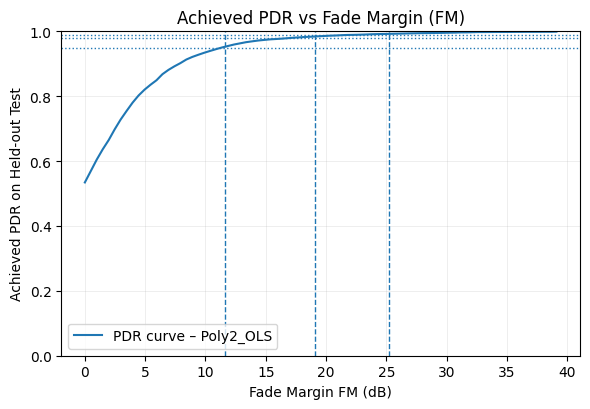

In [48]:
# ============================== Plot: PDR vs FM ===================================
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4.2))
plt.plot(fm_grid, pdr_grid, label=f"PDR curve – {MAIN_MODEL_FOR_FIG}")
# vertical lines at CV-calibrated FM(p) and horizontal lines at 1-p
for p in P_GRID:
    row = fm_table[(fm_table["model"] == MAIN_MODEL_FOR_FIG) & (fm_table["p"] == p)].iloc[0]
    fm_p = row["fm_sel"]
    plt.axvline(fm_p, linestyle='--', linewidth=1.0)
    plt.axhline(1.0 - p, linestyle=':', linewidth=1.0)

plt.title("Achieved PDR vs Fade Margin (FM)")
plt.xlabel("Fade Margin FM (dB)")
plt.ylabel("Achieved PDR on Held-out Test")
plt.ylim(0, 1.0)
plt.grid(True, which='both', linewidth=0.5, alpha=0.3)
plt.legend()
os.makedirs("Reports/FM", exist_ok=True)
fig_path = "Reports/FM/pdr_vs_fm.png"
plt.tight_layout()
#plt.savefig(fig_path, dpi=2000)
plt.show()

In [49]:
# ============================== Save CSV summaries ================================
os.makedirs("Reports/FM", exist_ok=True)

fm_csv = "Reports/FM/fm_calibration_summary.csv"
validation_csv = "Reports/FM/fm_validation_summary.csv"
fm_table.to_csv(fm_csv, index=False)
validation_df.to_csv(validation_csv, index=False)

print("Saved:", fm_csv)
print("Saved:", validation_csv)

Saved: Reports/FM/fm_calibration_summary.csv
Saved: Reports/FM/fm_validation_summary.csv


In [50]:
# ==============================  snippets ==============================
def paper_snippet(model_name, p=0.01):
    sub = fm_table[(fm_table["model"] == model_name) & (fm_table["p"] == p)].iloc[0]
    val = validation_df[(validation_df["model"] == model_name) & (validation_df["p_target"] == p)].iloc[0]
    fm = sub["fm_sel"]; lo = sub["fm_sel_lo"]; hi = sub["fm_sel_hi"]; est = sub["selected"]
    ach_p = val["achieved_outage"]; ach_pdr = val["achieved_PDR"]
    return (
        f"FM calibration for {model_name}: For p={p:.2%}, we obtain FM99 = {fm:.2f} dB "
        f"[95% BCa: {lo:.2f}, {hi:.2f}] using {est}. On held-out test, achieved outage "
        f"is {ach_p:.2%} (PDR={ach_pdr:.2%}), lying on the target iso-line."
    )

for m in SELECTED_MODELS_FOR_FM:
    print(paper_snippet(m, p=0.01))

FM calibration for Poly2_OLS: For p=1.00%, we obtain FM99 = 25.18 dB [95% BCa: 23.64, 23.64] using gmm-tail. On held-out test, achieved outage is 0.79% (PDR=99.21%), lying on the target iso-line.
FM calibration for MLR_linear: For p=1.00%, we obtain FM99 = 28.04 dB [95% BCa: 28.63, 28.63] using empirical. On held-out test, achieved outage is 0.98% (PDR=99.02%), lying on the target iso-line.
